In [1]:
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
from pylab import rcParams
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.filters import sobel_h

In [20]:
rcParams['figure.figsize'] = 28,48

In [3]:
from ImageHandler import *
from ImageProcessing import *
from Processing import *

'Found 1485 components with height 8.606734006734007 in image'

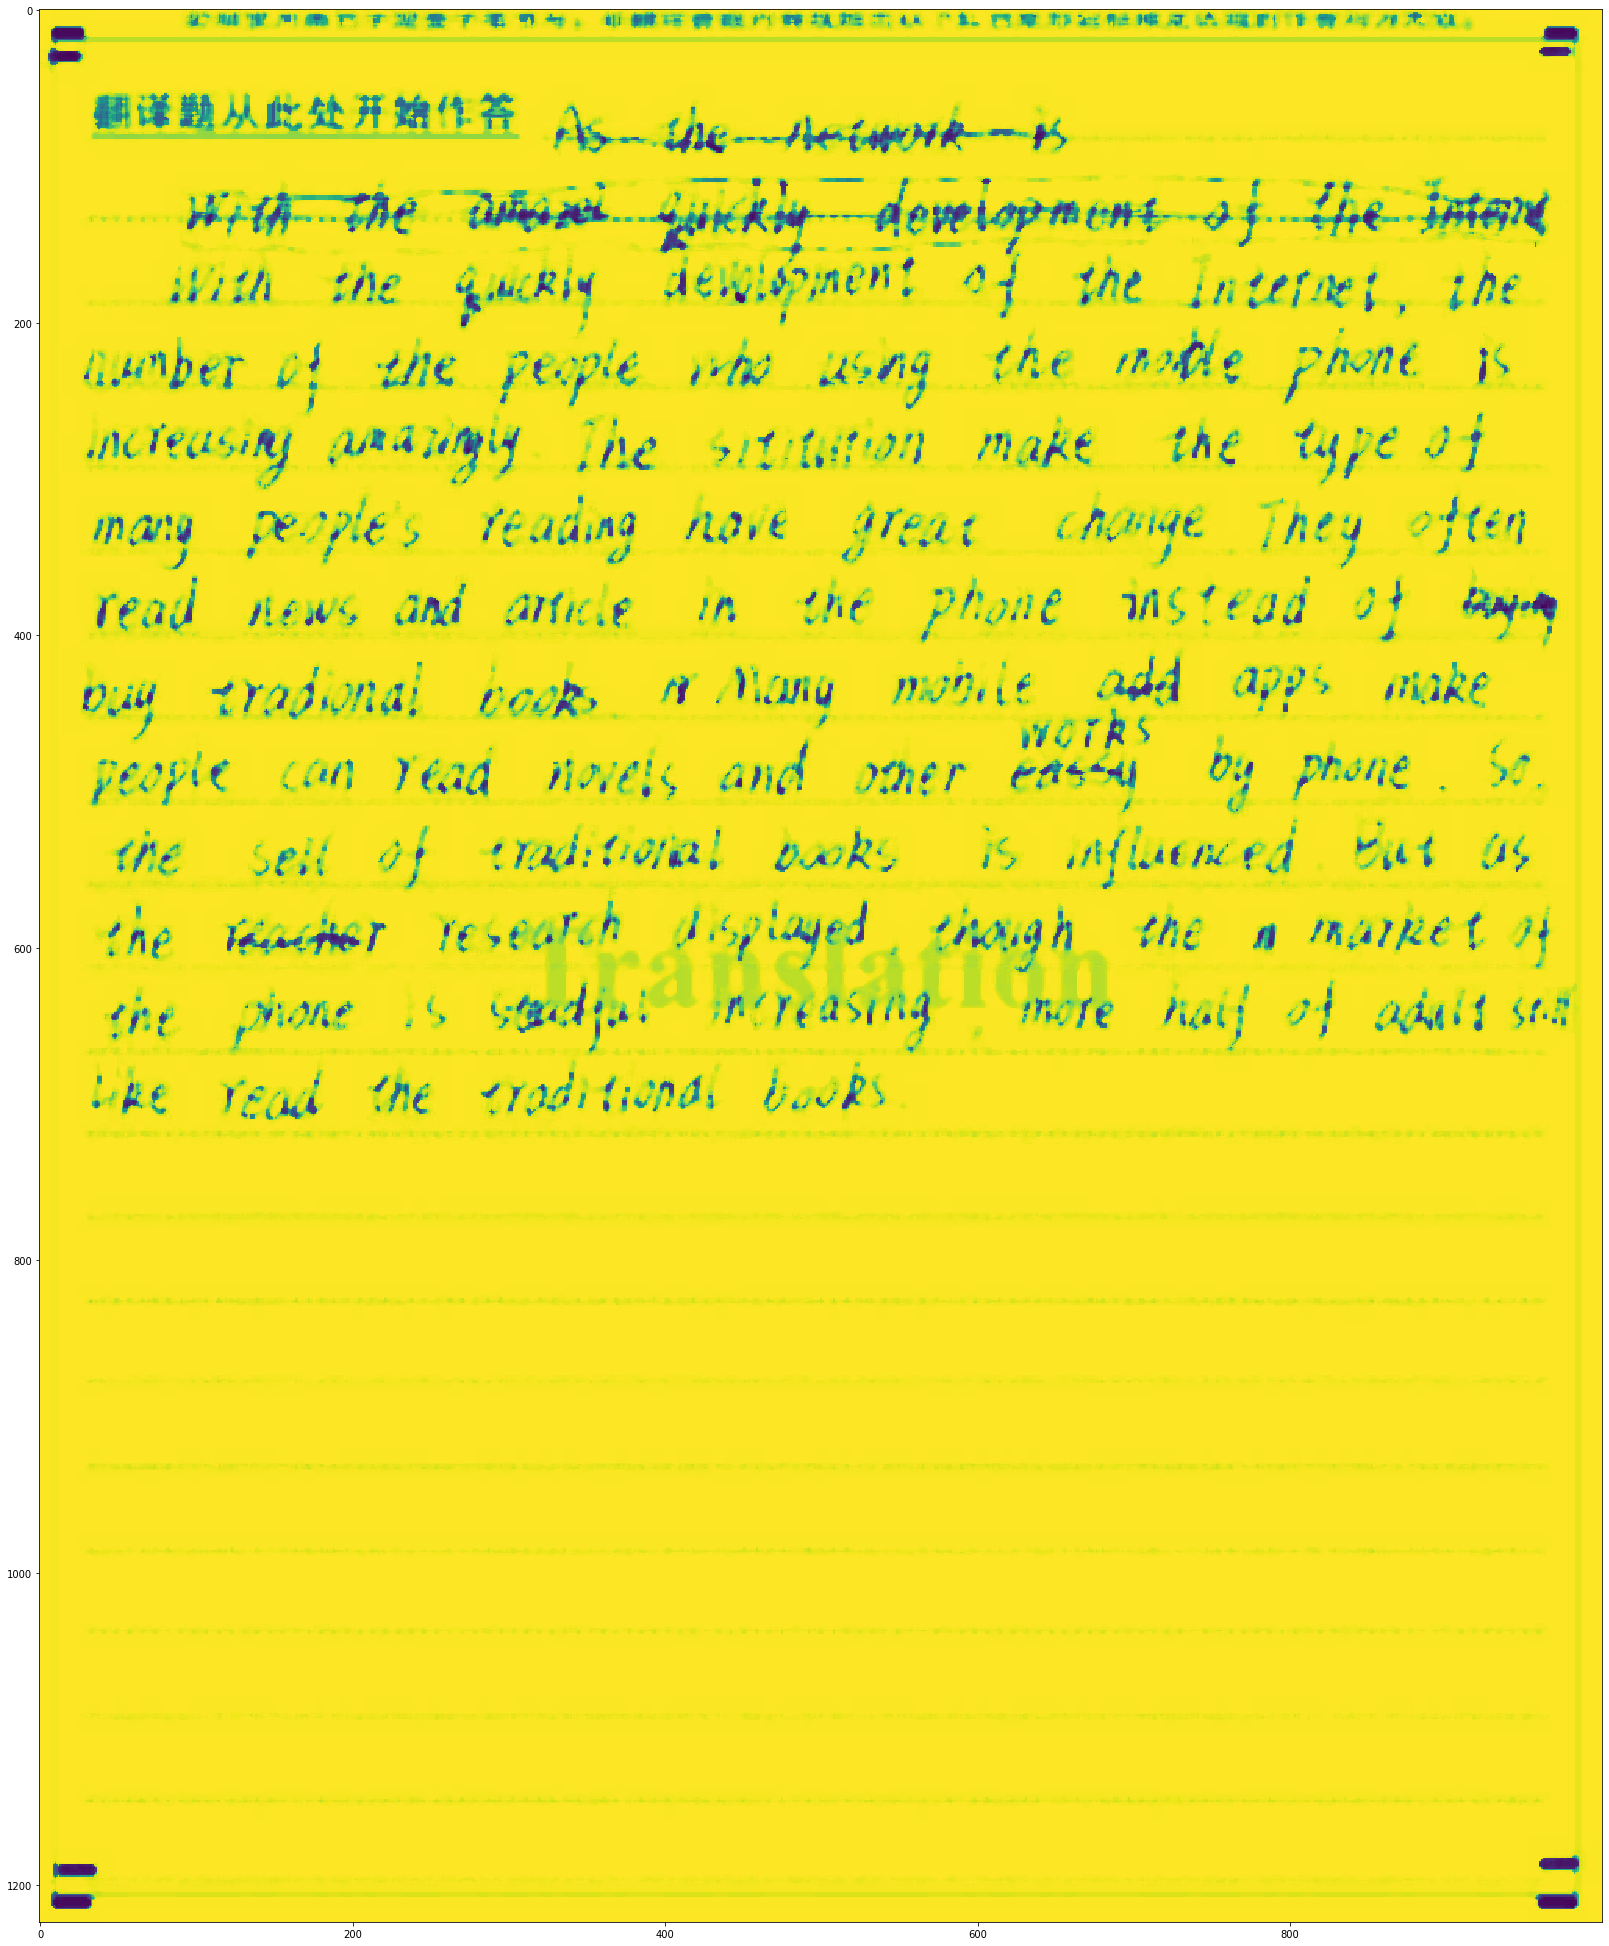

In [126]:
image = cv.imread(cv.samples.findFile("../Dataset/600000002.jpg"), 0);
image = cv.medianBlur(image, 5)
(h, w) = np.shape(image);
plt.imshow(image)
width = int (findComponents(image));

In [127]:
# replace pixel with avg gray value 
def PPA(image, width):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 32),
                         sharex=True, sharey=True)

    ax = axes.ravel()
    
    stripped_image, strips = putGLM(np.copy(image), width);
#     plt.imshow(stripped_image);
#     plt.show();
    ax[0].imshow(stripped_image);
    ax[0].set_title('GLM Image', fontsize=20);
    
    # apply otsu's algo
    th = np.copy(stripped_image);
    for i in range(strips):
        l = i * width;
        r = (i+1) * width if (((i+1) * width) < w) else w
        _,th[:,l:r] = cv.threshold(stripped_image[:,l:r],0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#     plt.imshow(th);
#     plt.show()
    ax[1].imshow(th);
    ax[1].set_title('Otsu Algo', fontsize=20);
    
    filteredWImage = filterWhite(np.copy(th), strips, width)
    Wheight = avgWhiteH(np.copy(th), strips, width)
#     plt.imshow(filteredWImage);
#     plt.show();
    ax[2].imshow(filteredWImage);
    ax[2].set_title('Filtered White Blocks', fontsize=20);
    
    filteredBImage = filterBlack(np.copy(filteredWImage), strips, width)
#     plt.imshow(filteredBImage);
#     plt.show();
    ax[3].imshow(filteredBImage);
    ax[3].set_title('Filtered Black Blocks', fontsize=20);
    
    mode = modeWhite(np.copy(filteredBImage), strips, width);
    return mode, filteredBImage, strips, Wheight;

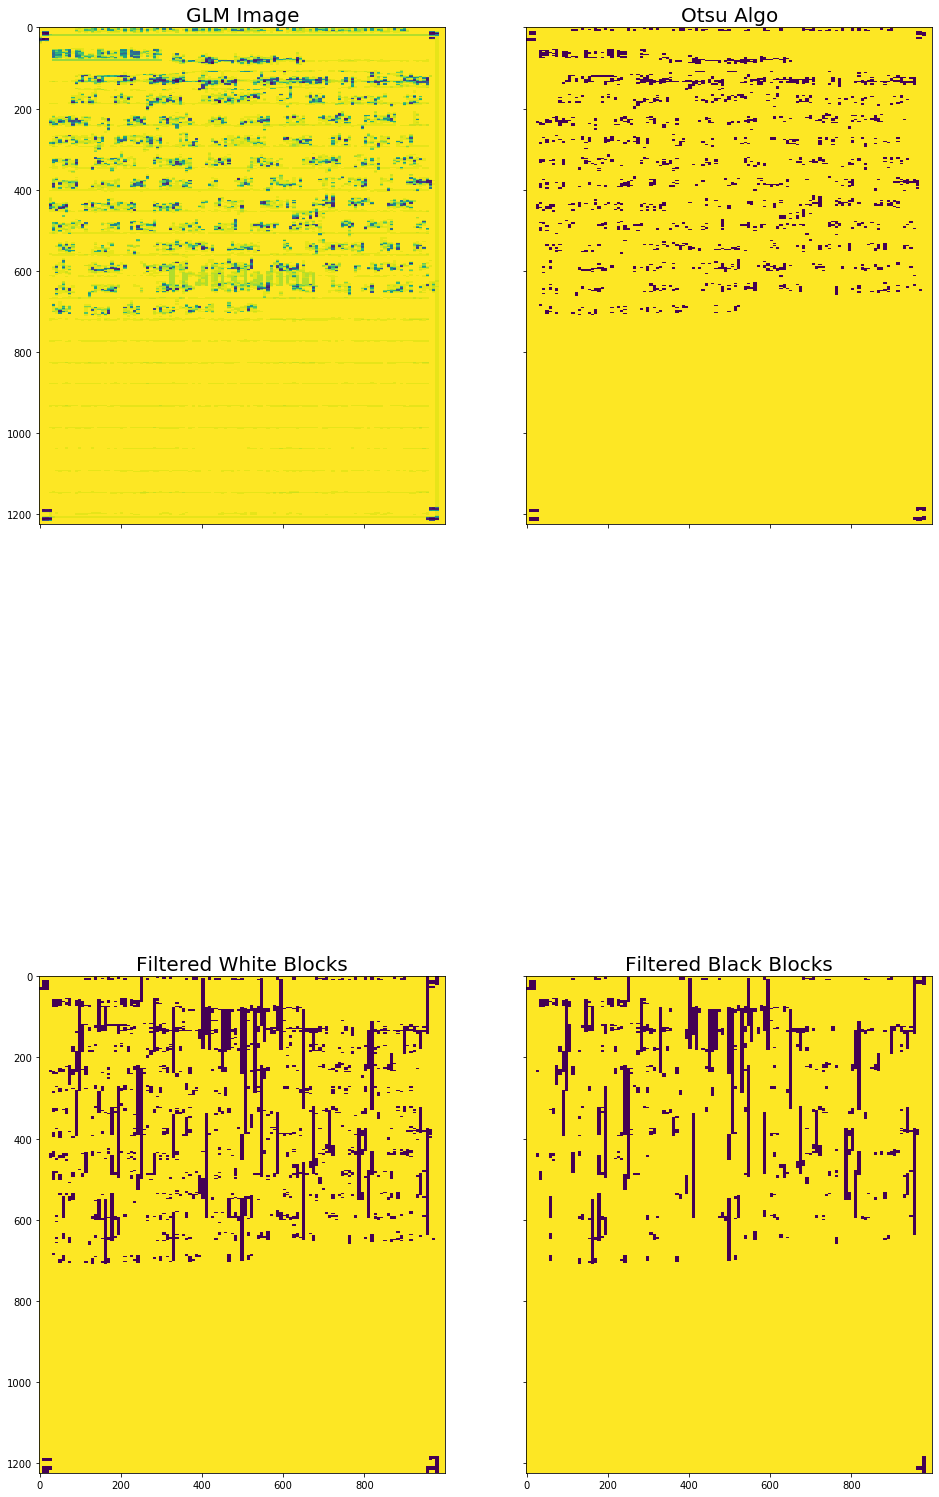

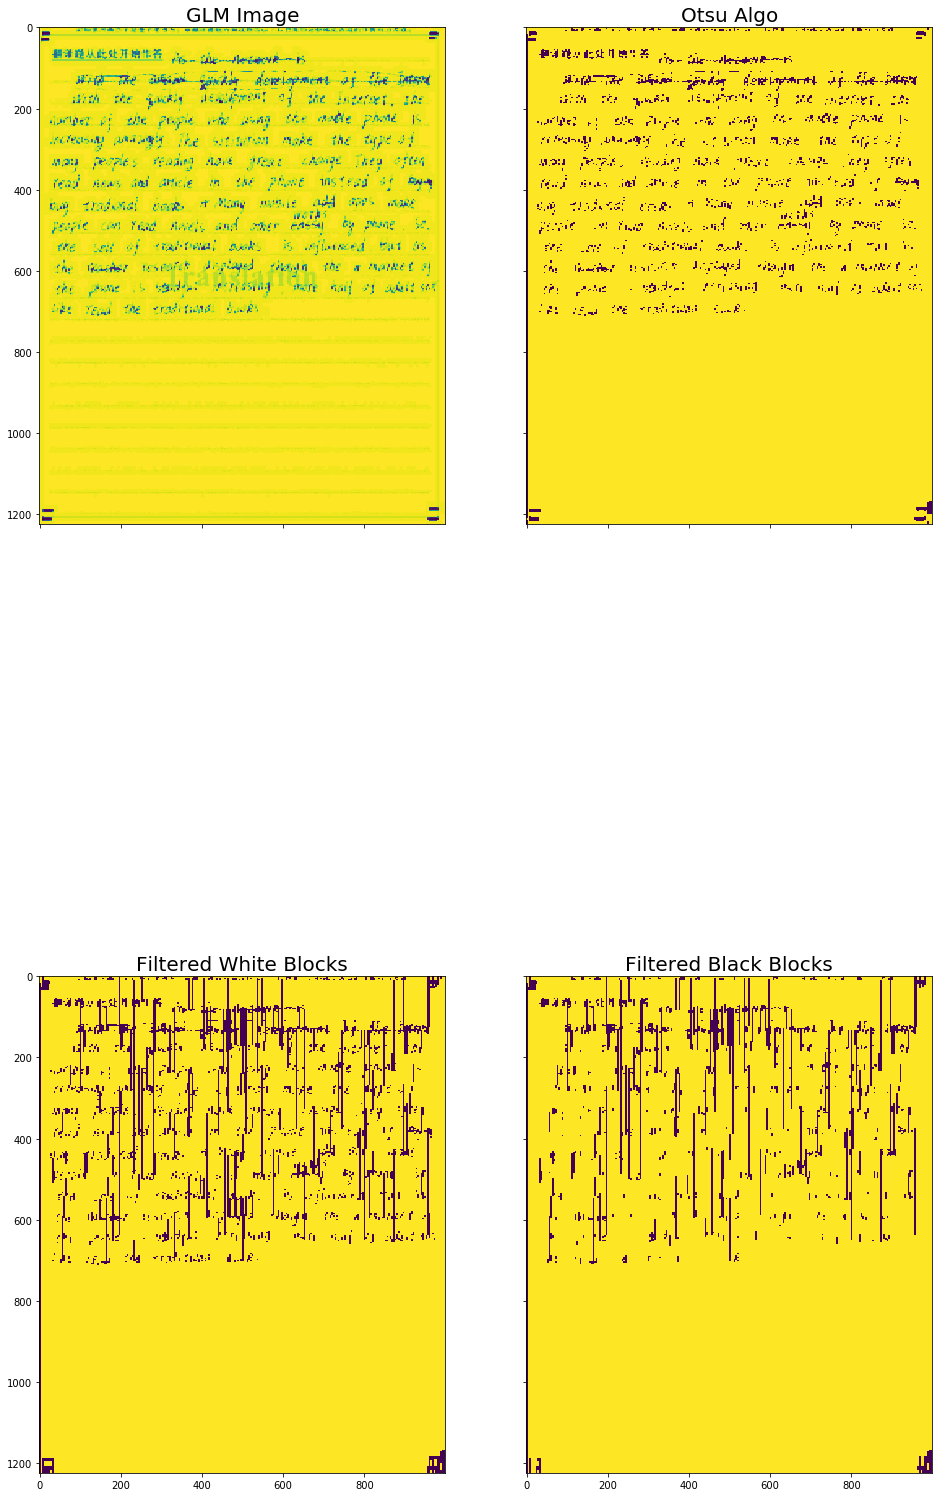

In [128]:
new_width, filteredBImage, strips, height = PPA(image, width)
mode, filteredBImage, strips, height = PPA(image, new_width)

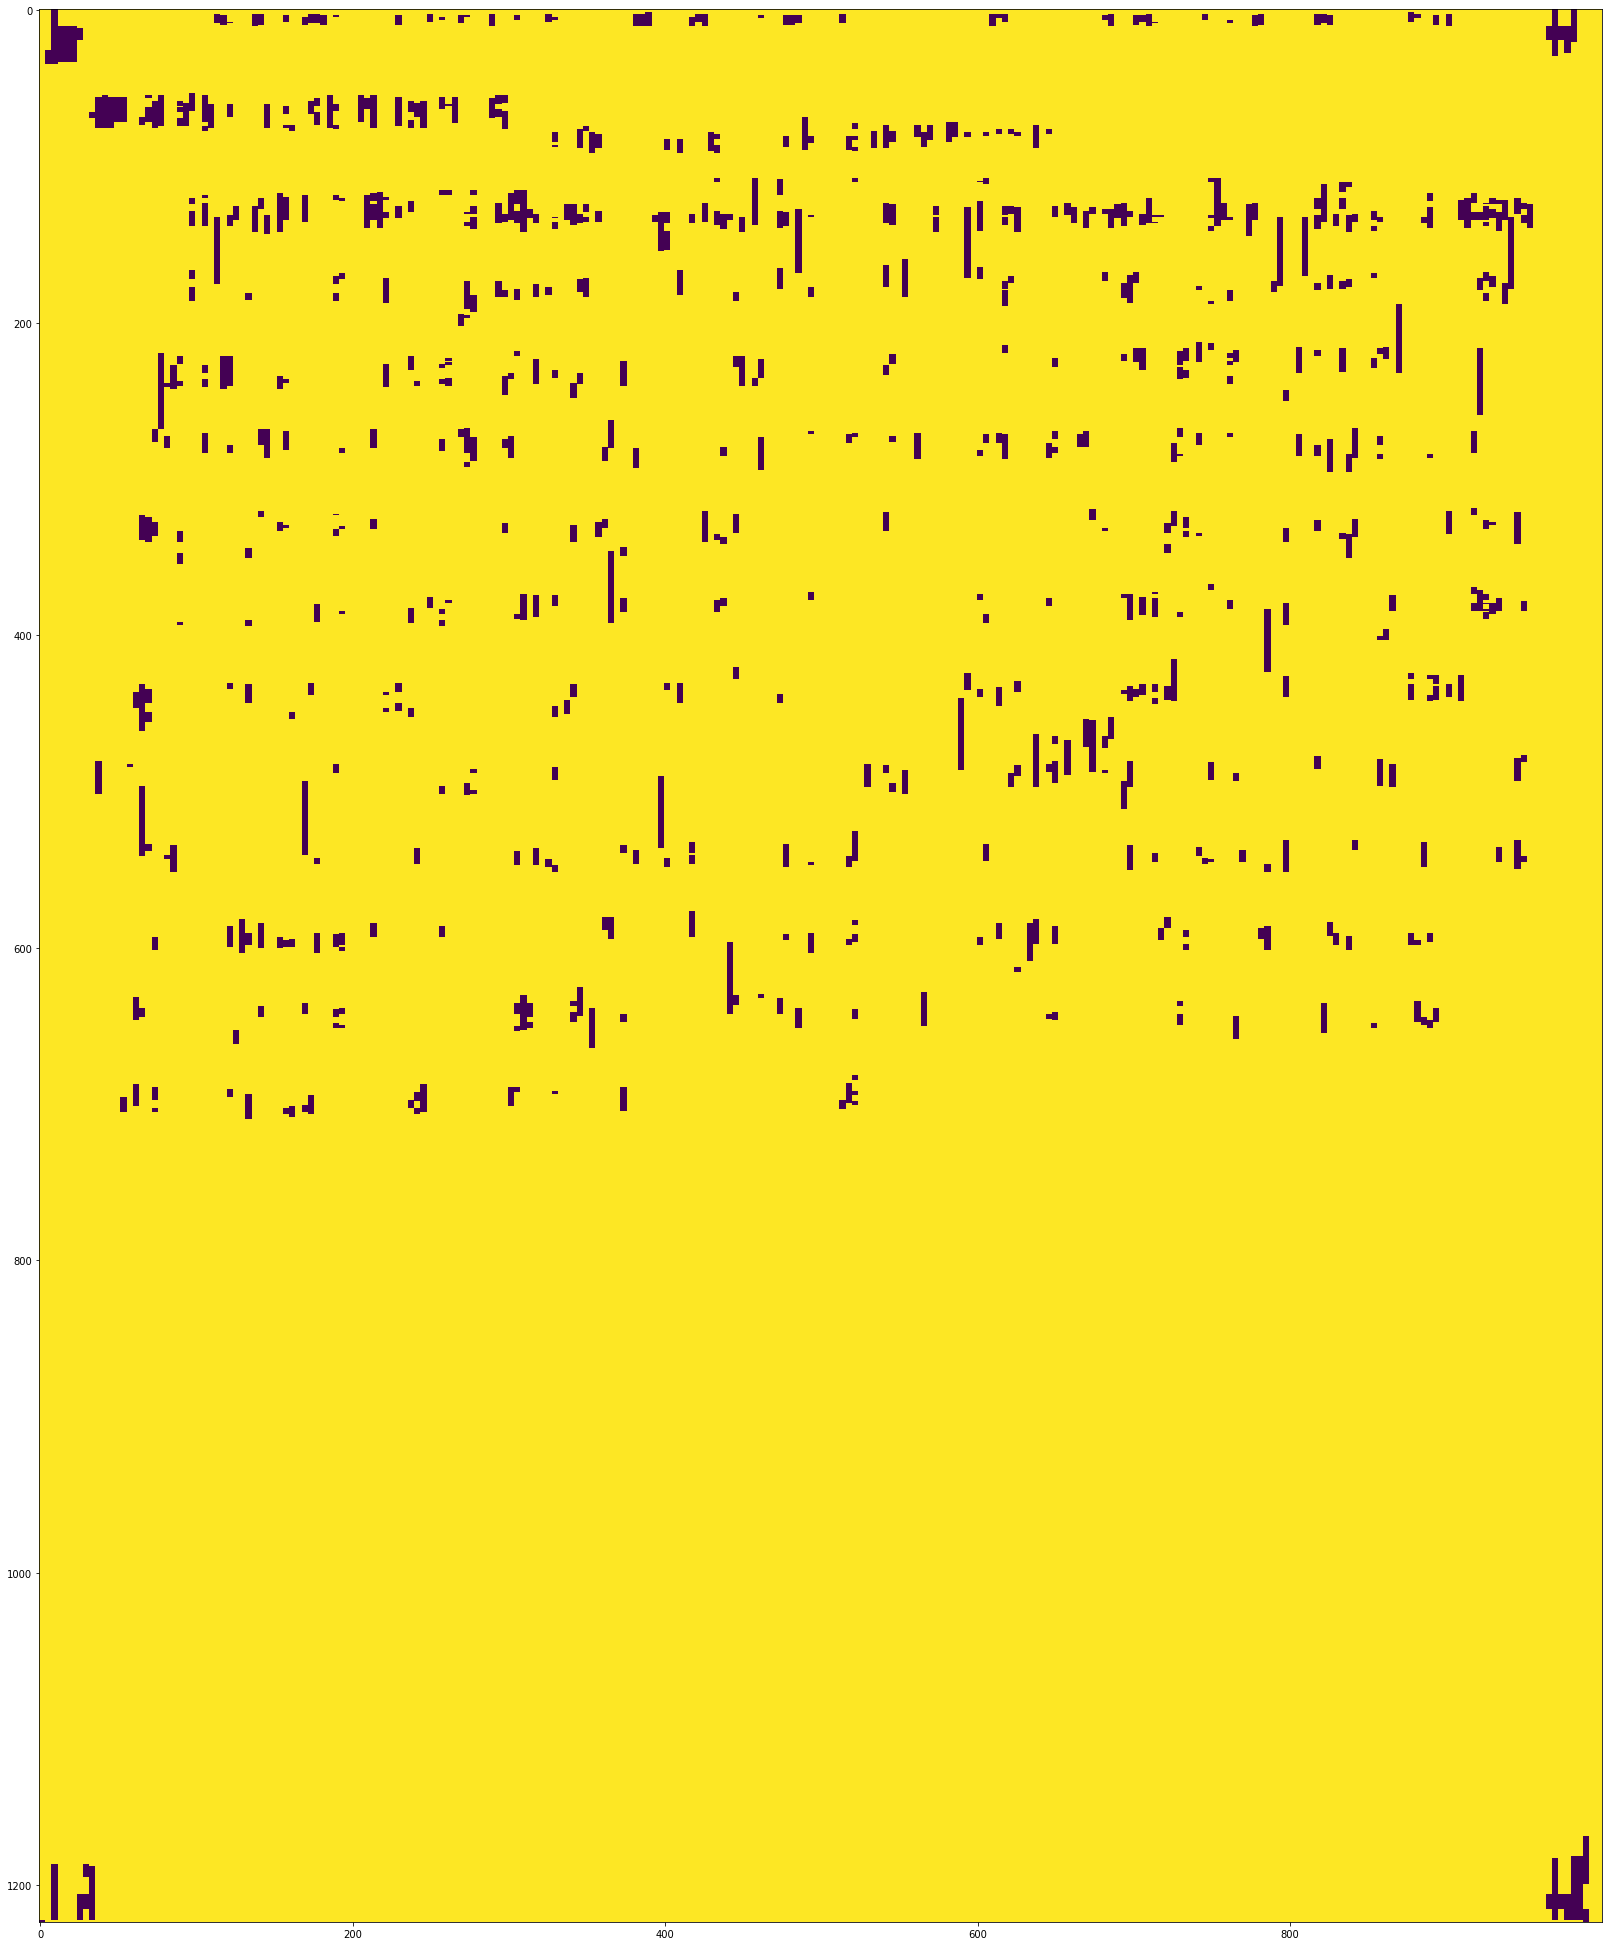

In [129]:
# Remove black block equal or greater than twice of avg
avgBH = removeBlack(np.copy(filteredBImage), strips, new_width);
plt.imshow(avgBH);

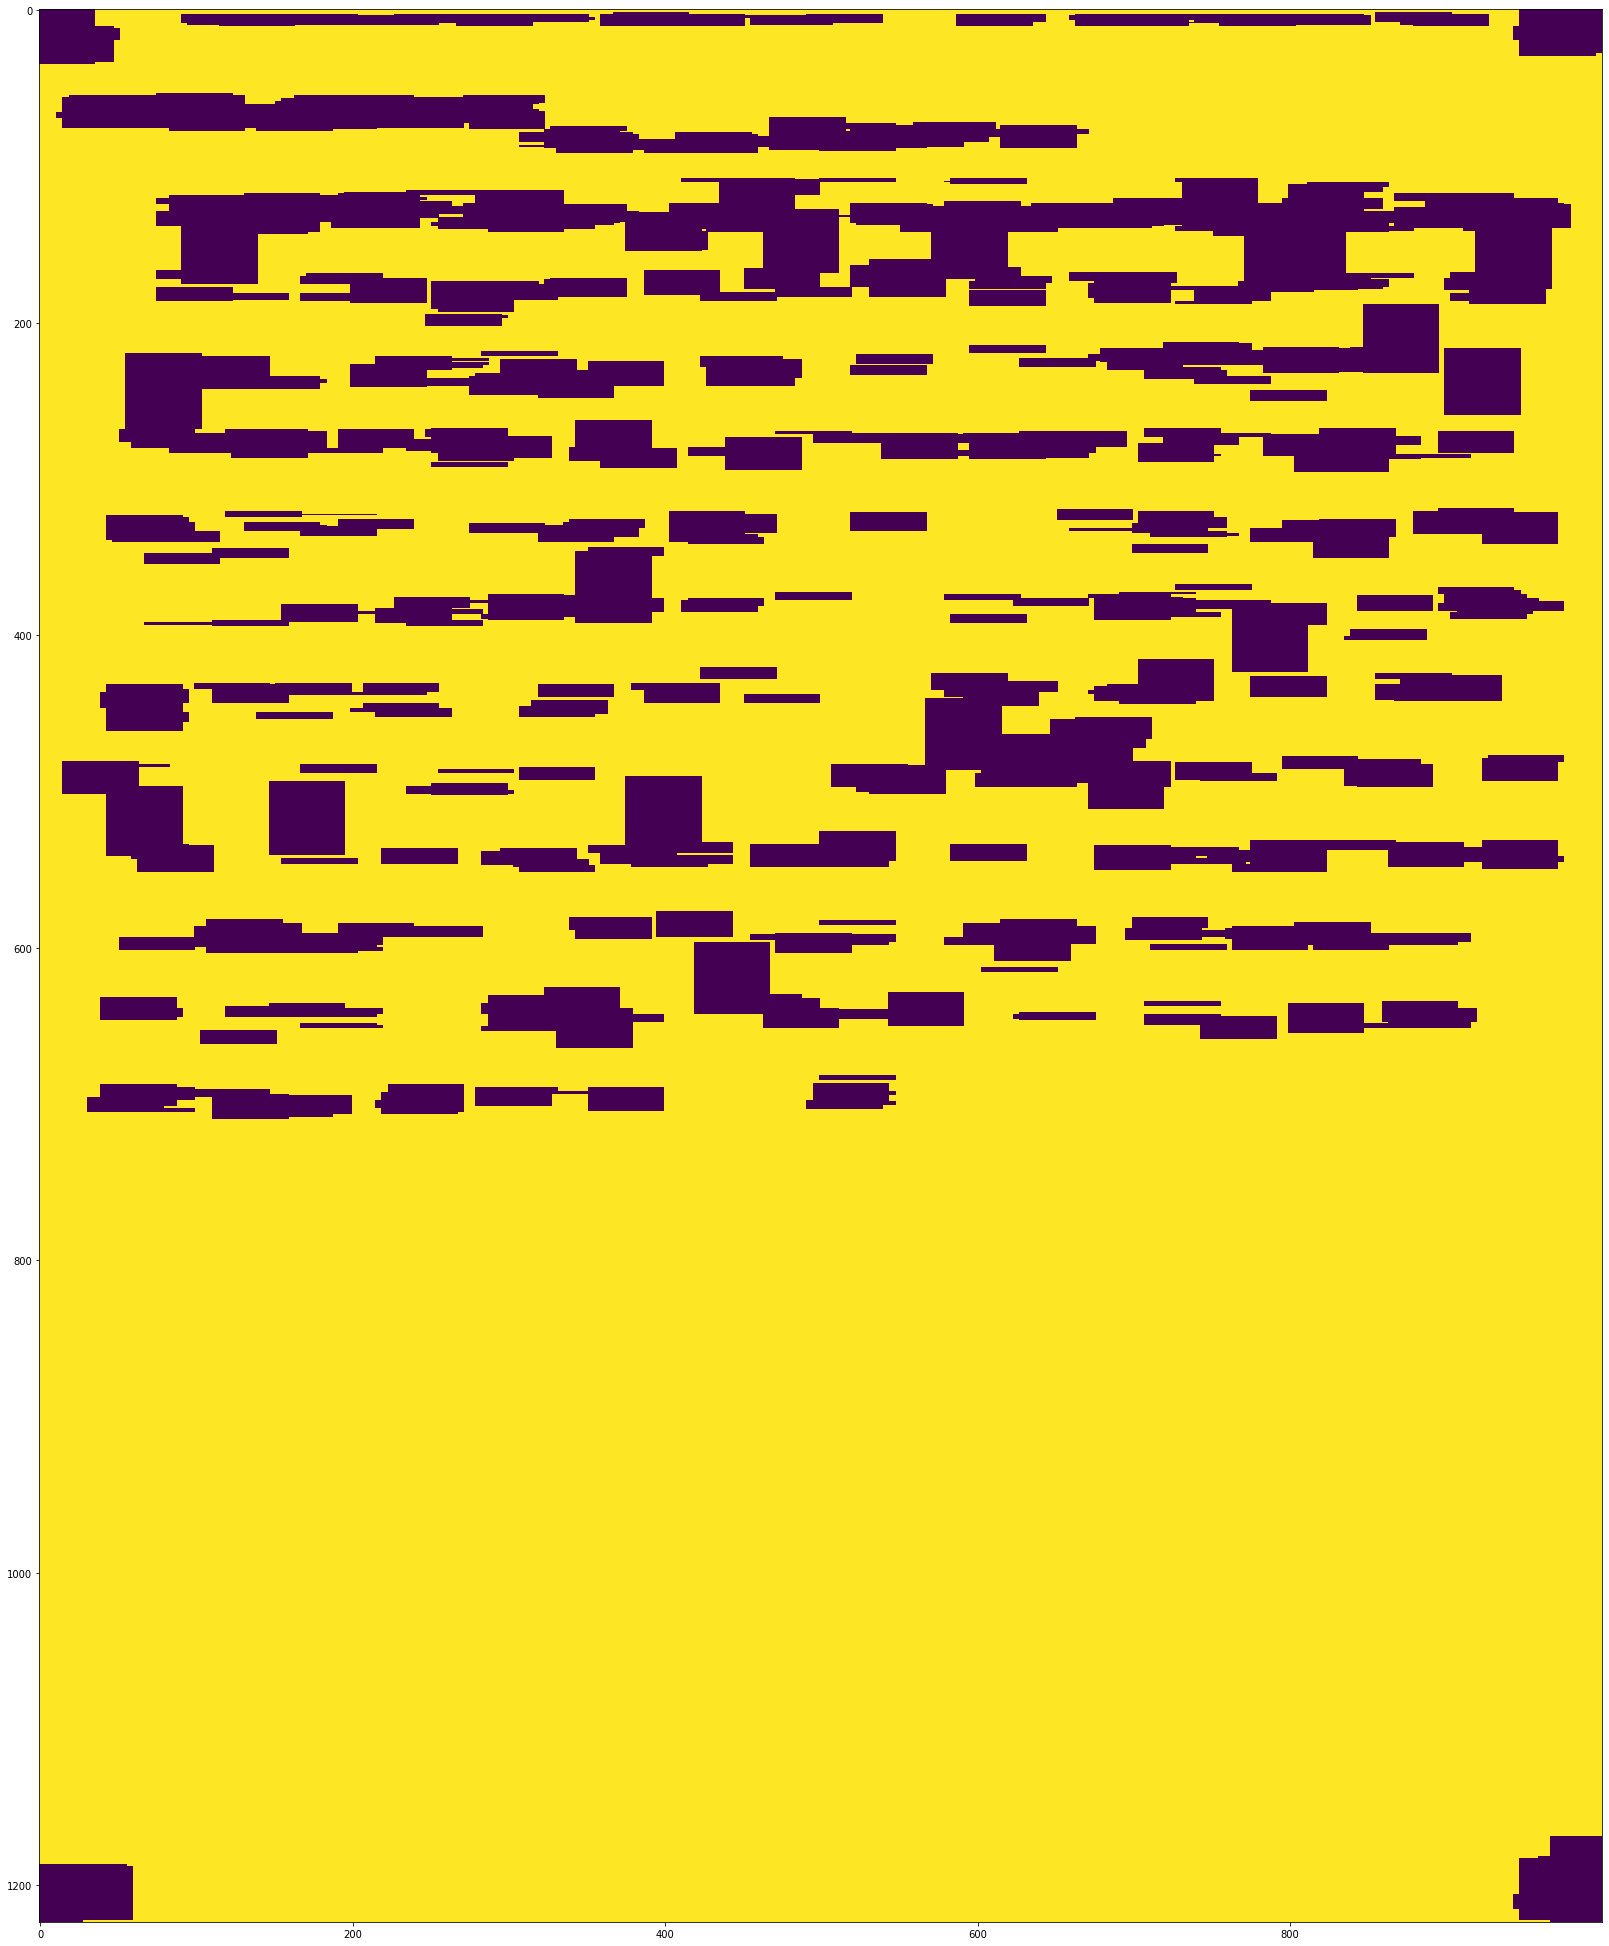

In [130]:
# Invert image and then dilate and invert it back
img = [];
for row in avgBH:
    rows = [];
    for ele in row:
        if (ele == 255):
            rows.append(0);
        else:
            rows.append(255);
    img.append(rows);
img = np.array(img, dtype = np.uint8);
dilated_img = cv.dilate(img, np.ones((1,4* new_width),np.uint8), iterations=3)
plt.imshow(dilated_img);
img = [];
for row in dilated_img:
    rows = [];
    for ele in row:
        if (ele == 255):
            rows.append(0);
        else:
            rows.append(1);
    img.append(rows);
img = np.array(img, dtype = np.uint8);
plt.imshow(img);

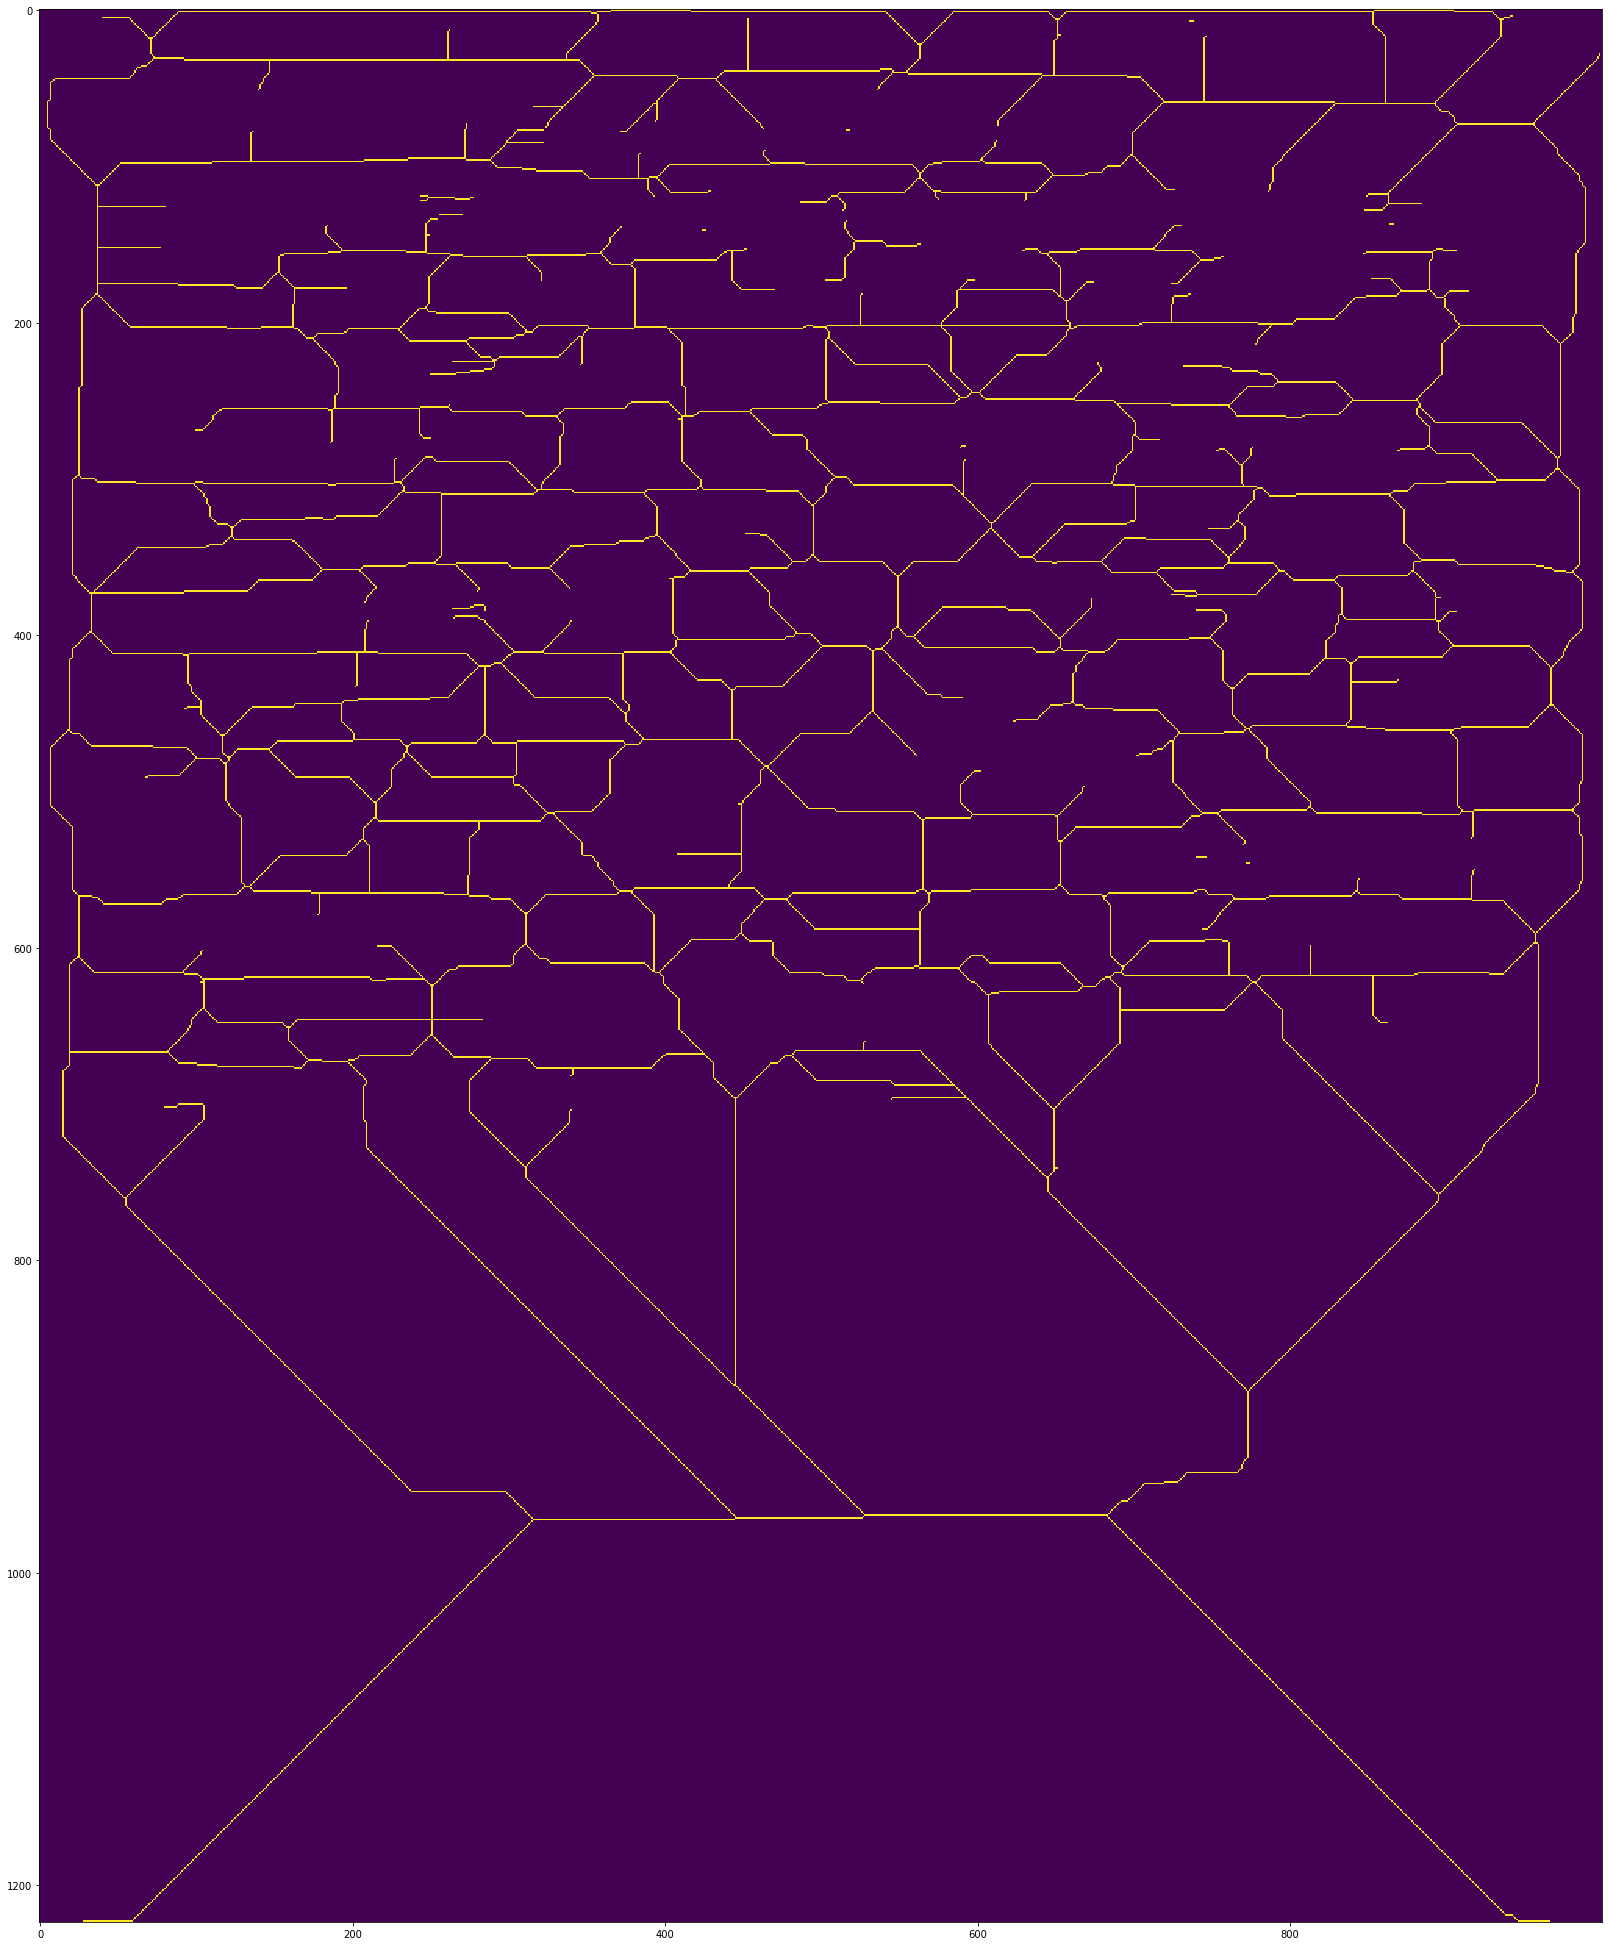

In [131]:
# Perform thinning
skel = skeletonize(img)
plt.imshow(skel)

'497 lines found'

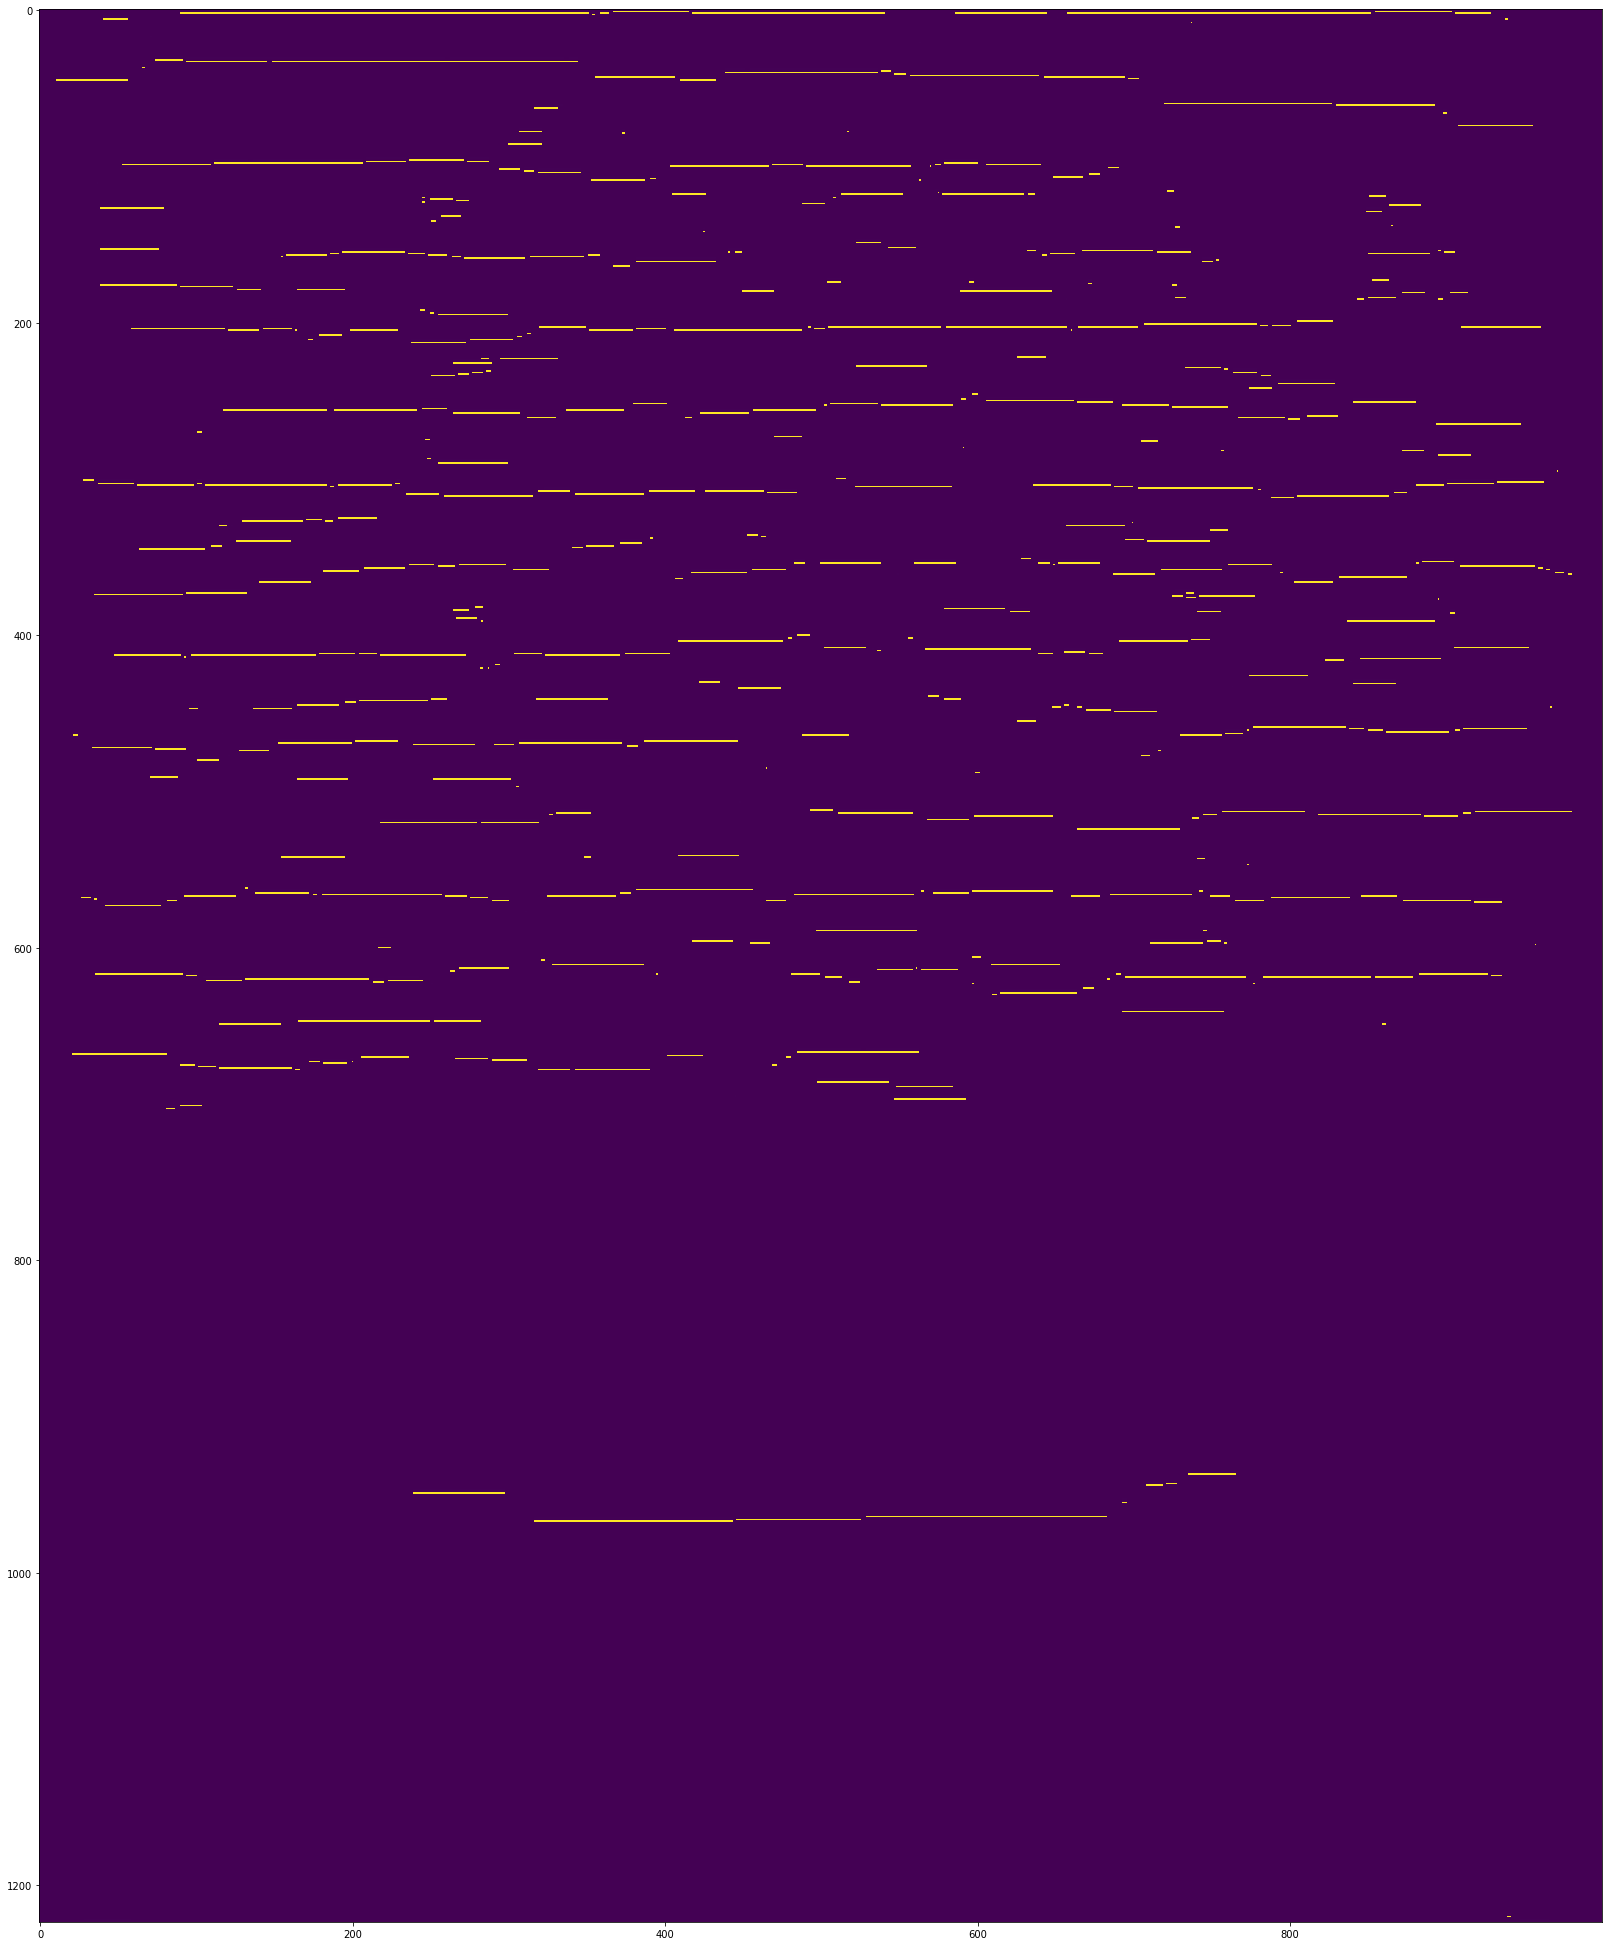

In [132]:
# Apply Sobel filter
sobel_img = sobel_h(skel)
pro_sobel_img, labels, stats = processSkeleton(np.copy(sobel_img))
plt.imshow(pro_sobel_img);

[  2.   5.   3.   4.   5.  -1.   7.   8.   9.  11.  11.  -1.  10.  14.
  15.  -1.  21.  21.  21.  20.  21.  -1.  19.  19.  25.  -1.  24.  28.
  30.  28.  -1.  30.  31.  30.  35.  36.  37.  -1.  39.  45.  41.  42.
  43.  44.  45.  -1.  47.  48.  42.  47.  49.  52.  53.  56.  56.  56.
  67.  58.  59.  56.  61.  62.  63.  59.  65.  63.  67.  -1.  69.  -1.
  71.  72.  73.  74.  69.  73.  74.  78.  76.  81.  81.  74.  83.  85.
  85.  -1.  84.  88.  89.  91.  91.  92.  -1.  92.  92.  96.  97.  92.
  97. 100. 101.  97. 101.  -1. 105. 107. 107.  -1. 107. 108. 111. 112.
 113. 109. 107. 116.  -1. 116. 119. 117. 118. 122. 123.  -1. 123. 126.
 124. 128. 125. 131. 131. 128. 130. 134.  -1. 136. 137.  -1. 139. 137.
 138. 142. 140. 139. 145.  -1. 147. 151. 147. 150. 151. 154. 153. 150.
 155.  -1. 155. 159. 159.  -1. 161. 164. 160. 164.  -1. 166. 167. 164.
 166.  -1. 171. 169. 170. 174.  -1. 174. 177. 178. 179.  -1.  -1.  -1.
 181.  -1. 183. 184.]


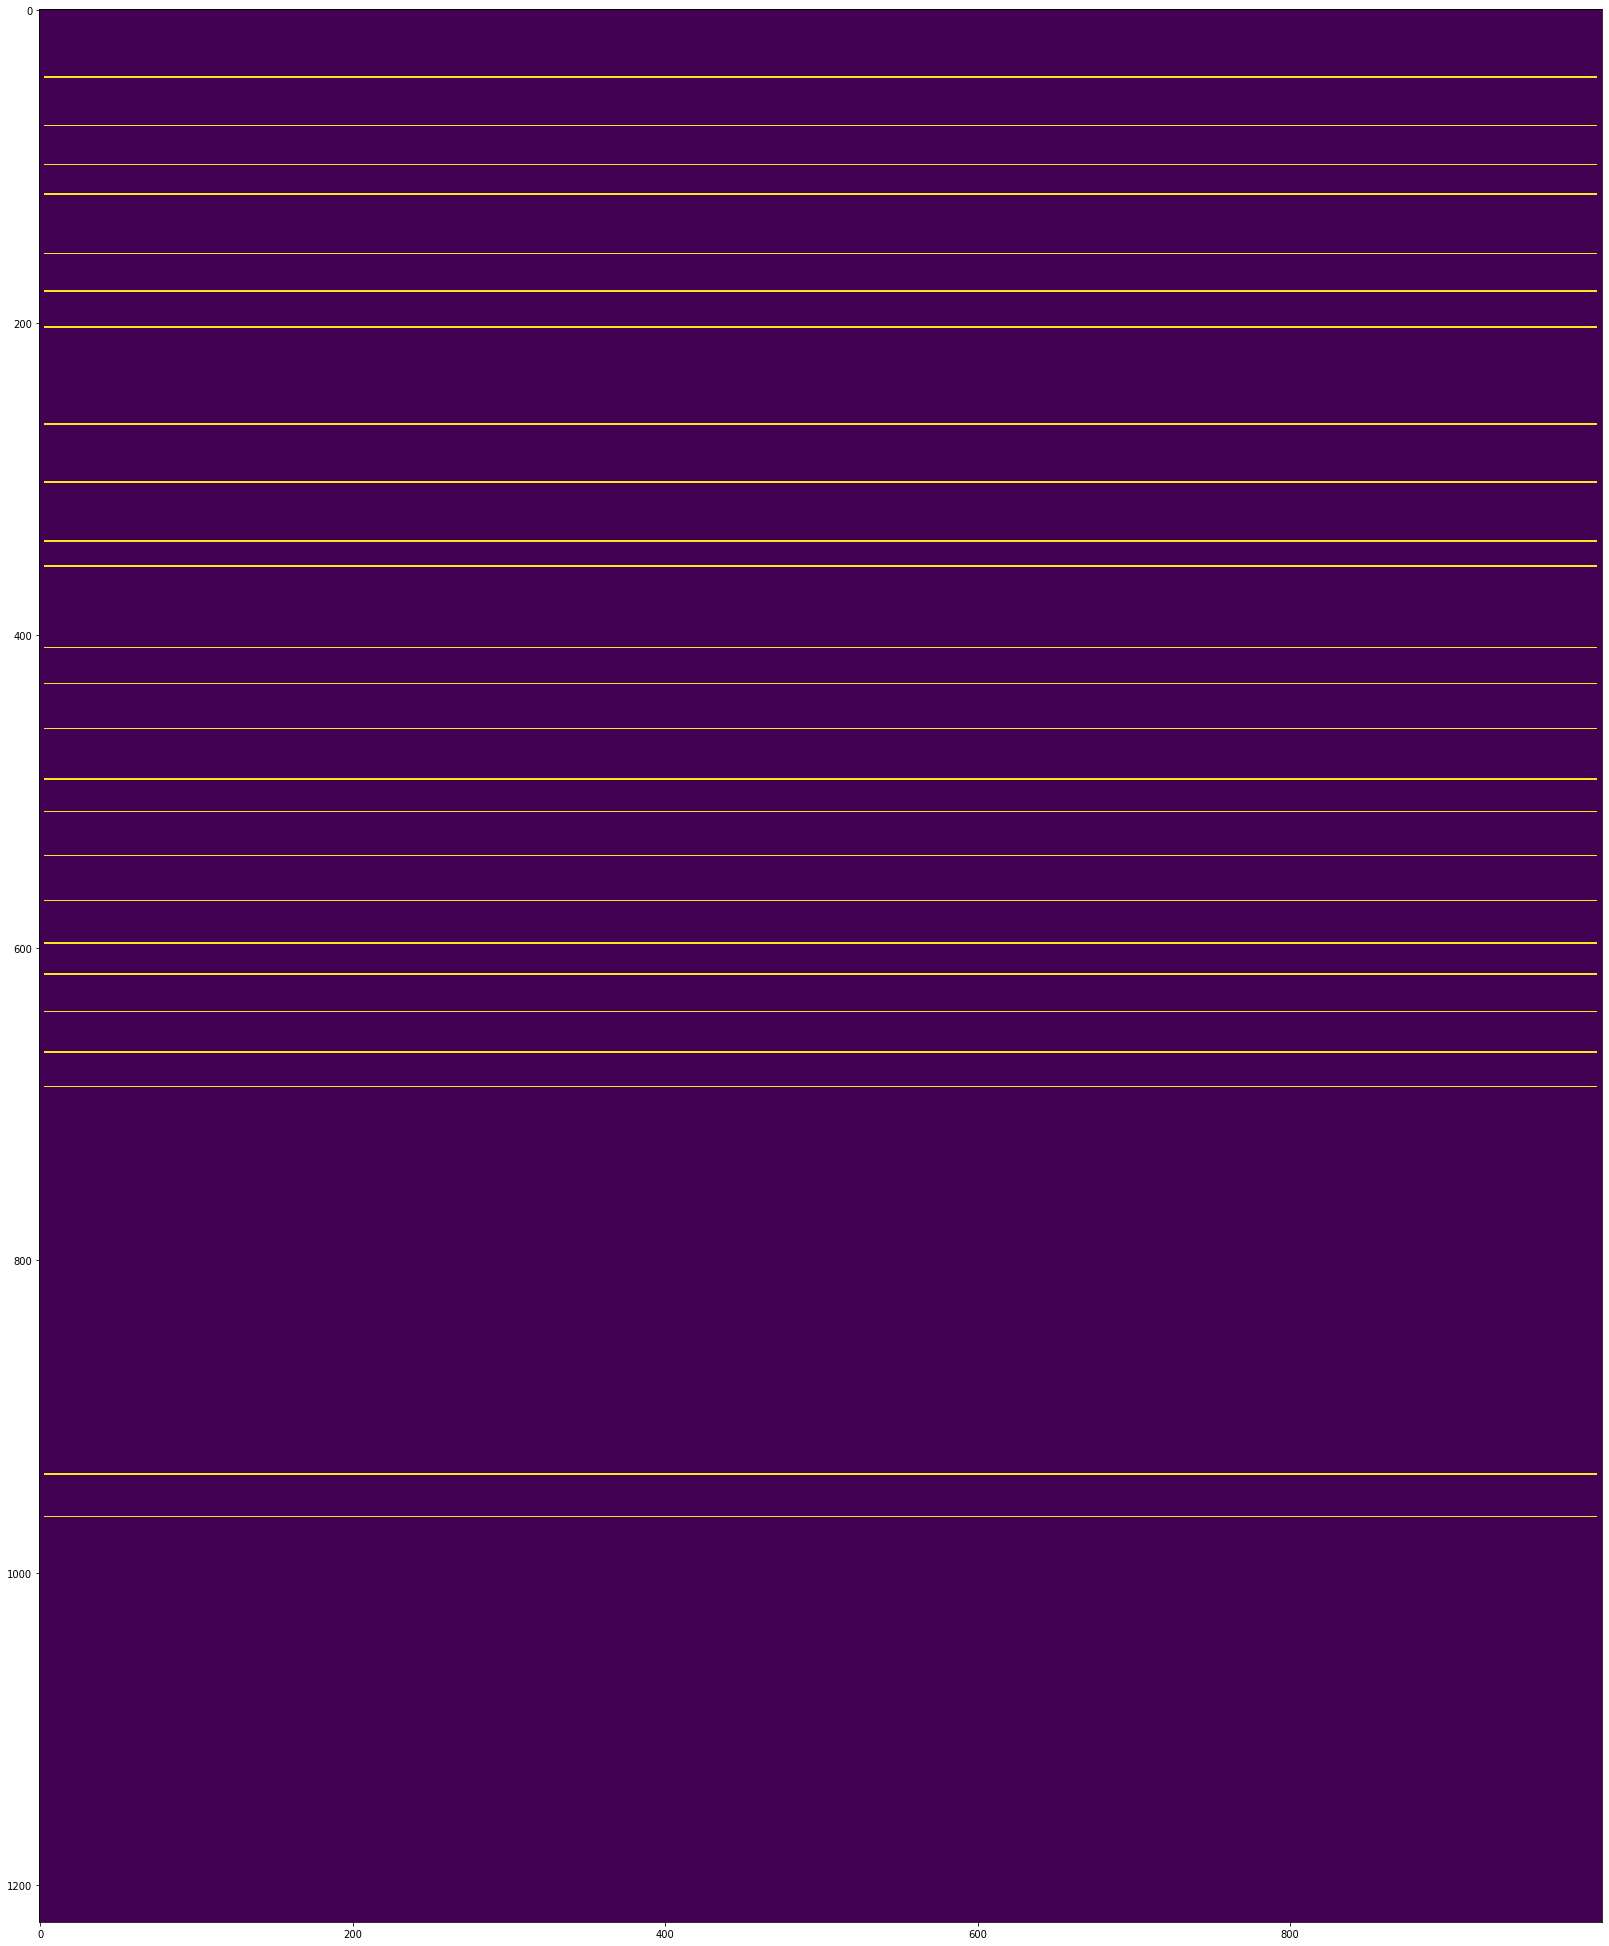

No of lines found 25


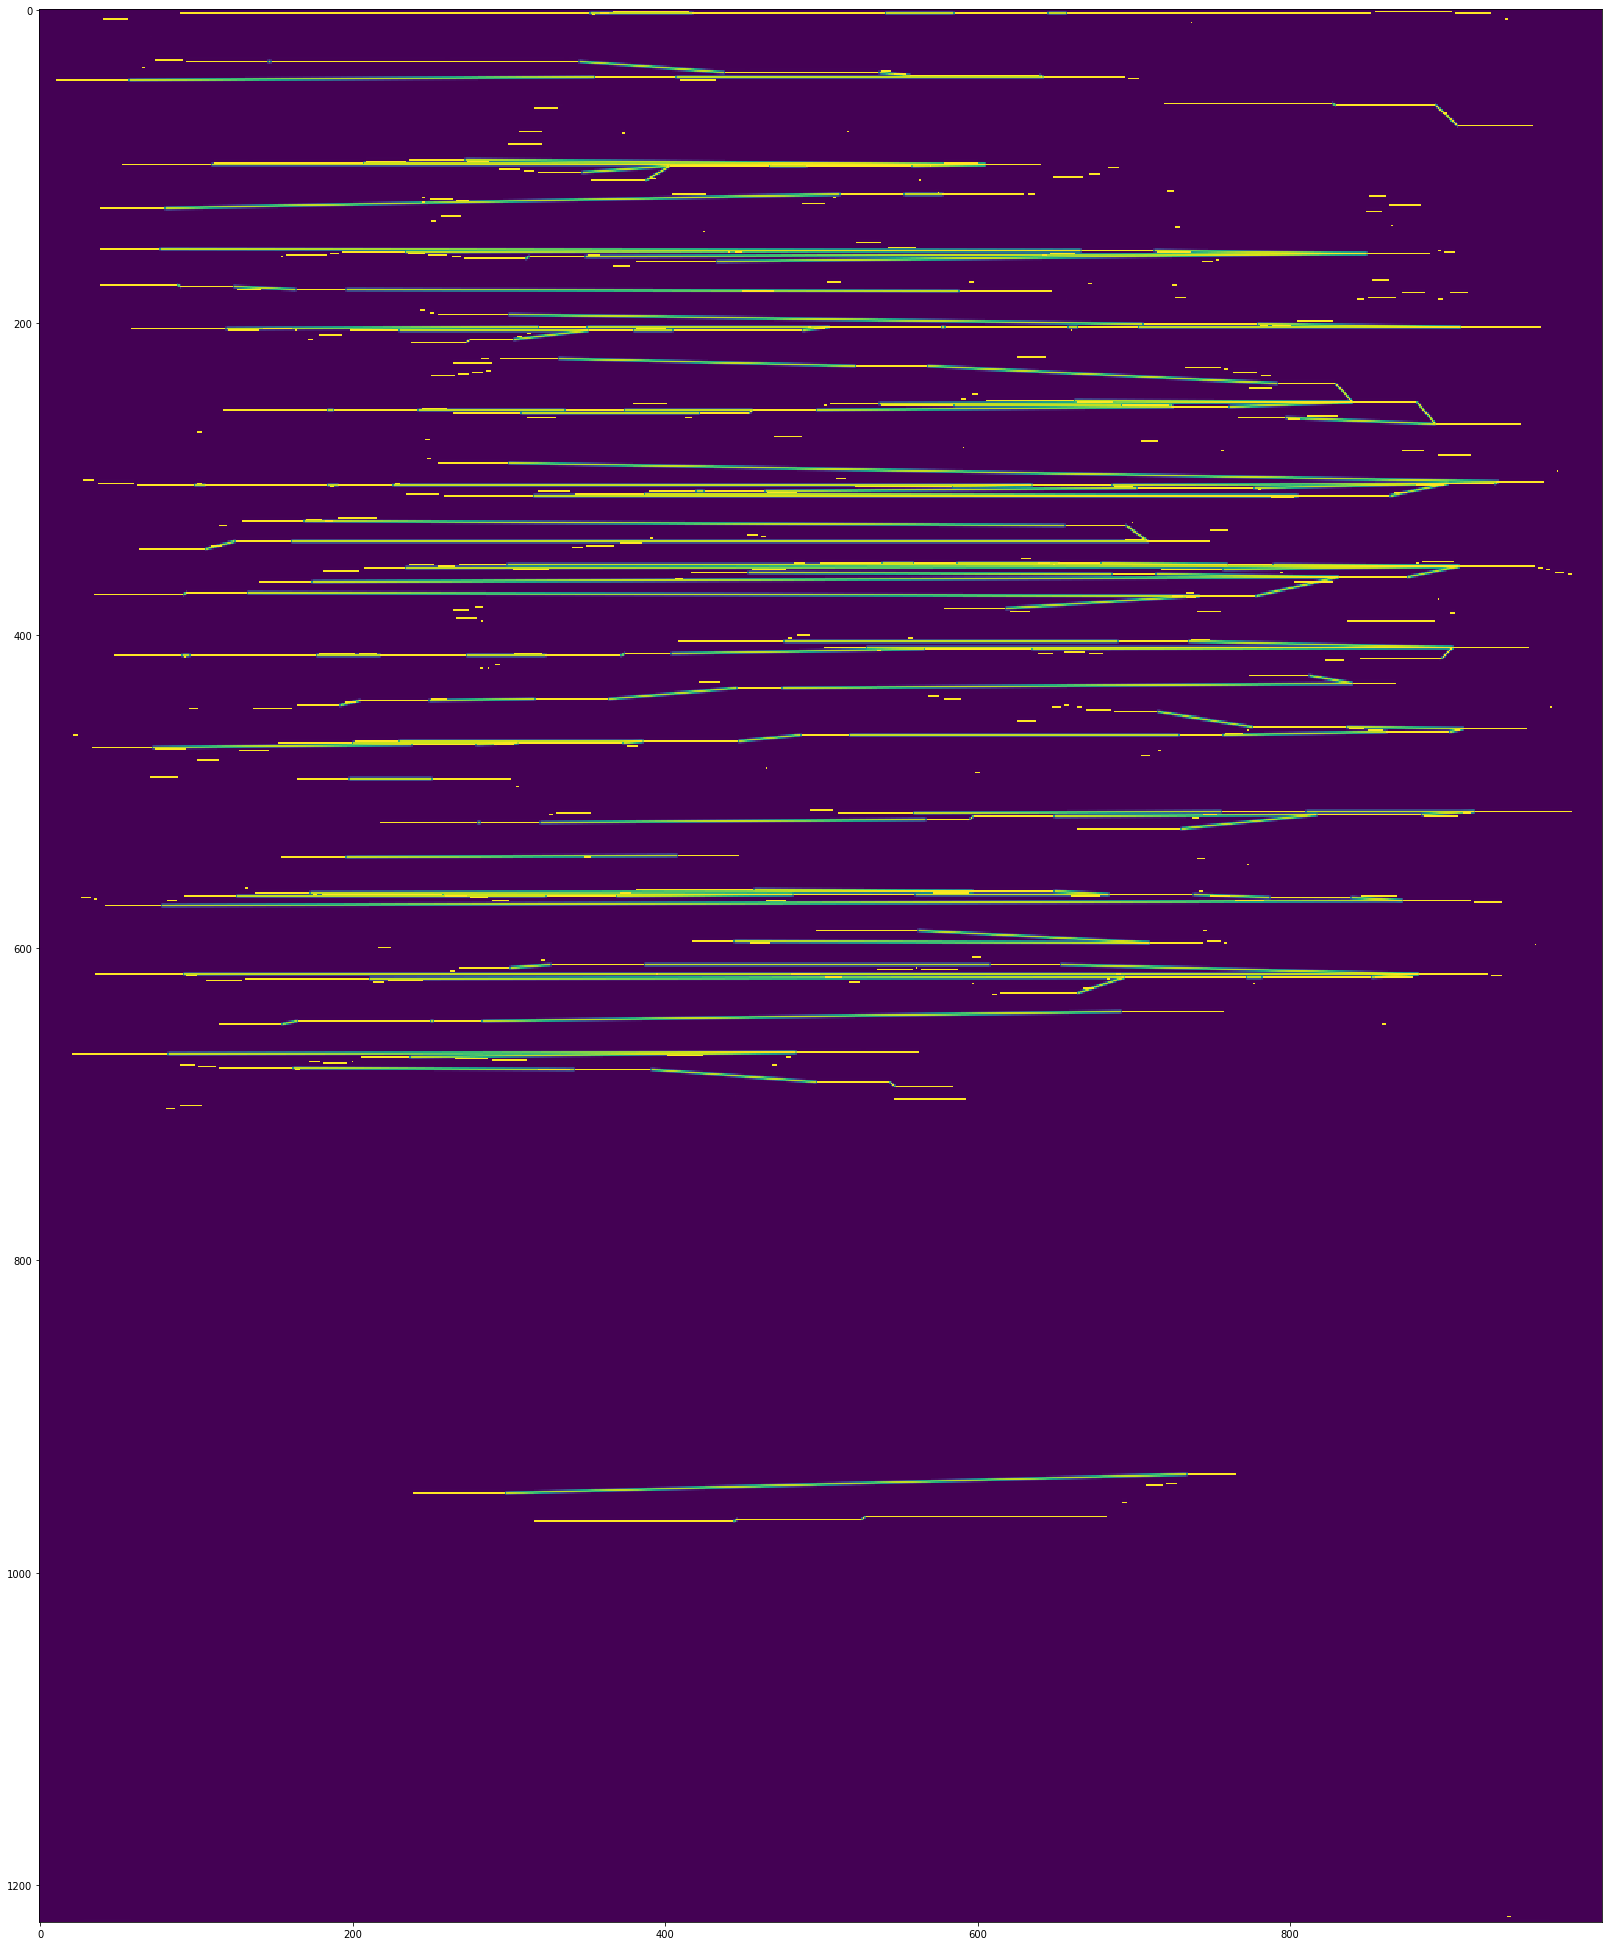

In [133]:
# Remove small lines, connect close lines and extend secluded lines
nstats = removeSmallLines(stats)
image, lines = connectLinesH(np.copy(pro_sobel_img), strips, new_width, nstats, img)
print ("No of lines found " + str(lines));
plt.imshow(image)

In [134]:
def connectLinesH(image, strips, width, stats, blockImage):
    (h,w) = np.shape(image);
    avgH = avgWhiteHLater(blockImage, strips, width);
    distMat = np.ones((len(stats))) * (-1);
    neighMat = np.ones((len(stats))) * (-1);
    

    for i in range(len(stats)):
        for j in range(len(stats)):
            dist = abs (stats[i][cv.CC_STAT_TOP] - stats[j][cv.CC_STAT_TOP]);
            if (stats[i][cv.CC_STAT_LEFT] + stats[i][cv.CC_STAT_WIDTH] <= stats[j][cv.CC_STAT_LEFT]):
                if (dist < avgH) and (distMat[i] == -1 or dist < distMat[i]):
                    distMat[i] = dist;
                    neighMat[i] = j;

    for i in range(len(distMat)):
        if distMat[i] != -1:
            j = int(neighMat[i]);
            x1 = int (stats[i][cv.CC_STAT_LEFT] + stats[i][cv.CC_STAT_WIDTH])
            y1 = int (stats[i][cv.CC_STAT_TOP] + 1)

            x2 = int (stats[j][cv.CC_STAT_LEFT])
            y2 = int (stats[j][cv.CC_STAT_TOP] + 1)

            cv.line(image, (x1, y1), (x2, y2), 255, 1, cv.LINE_AA);
            
    print (neighMat)
    
    (h,w) = np.shape(image);
    nimage = np.zeros((h,w), dtype=np.uint8);

    lines  = -1;
    for i in range(len(stats)):
        stat = stats[i];

        if i not in neighMat and stat[cv.CC_STAT_LEFT] < w/2 and neighMat[i] == -1 and stat[cv.CC_STAT_LEFT] + stat[cv.CC_STAT_WIDTH] > w/2:
            cv.line(nimage, (0, int (stat[cv.CC_STAT_TOP] + 1)), (w, int (stat[cv.CC_STAT_TOP] + 1)), 1, 1, cv.LINE_AA);
            lines += 1;
        elif (neighMat[i] == -1 and i in neighMat) or (neighMat[i] == -1 and i not in neighMat and stat[cv.CC_STAT_WIDTH] >= w):
            cv.line(nimage, (0, int (stat[cv.CC_STAT_TOP] + 1)), (w, int (stat[cv.CC_STAT_TOP] + 1)), 1, 1, cv.LINE_AA);
            lines += 1;
    plt.imshow(nimage);
    plt.show()
    return image, lines;

In [110]:
avgWhiteHLater(img,strips, new_width)

34

In [113]:
len(stats)

31

In [ ]:
  1.  5. -1.  0.  1.  6.  6.  0.  0.  0.  0. -1.  2. -1.
  4. -1.  1. 10.  0.  1.  5.  0.  3.  1.  0.  0.  4. -1.  0.  1.  3. -1.
  1.  3.  0.  1.  0. -1.  2.  1.  9.  5. -1.  5.  0.  6. -1.  1.  1.  1.
  0.  6.  2.  0.  4. -1.  1.  9. -1.  1.  2.  5.  0.  0.  1.  0.  3.  1.
  0. -1.  0.  2.  0.  8. -1.  5.  0.  2.  0.  0.  1.  0.  1.  0.  0.  1.
 -1.  7.  1. -1.  2. -1.  0.  0.  0.  0.  1.  3.  0.  1.  1. -1.  6.  2.
 -1.  4.  0.  1.  1.  0.  2.  1.  0. -1.  2.  6. -1.  0.  0.  1.  0.  2.
  0.  4.  1. -1.  6. 11.  3.  3. -1. -1. -1. -1.]

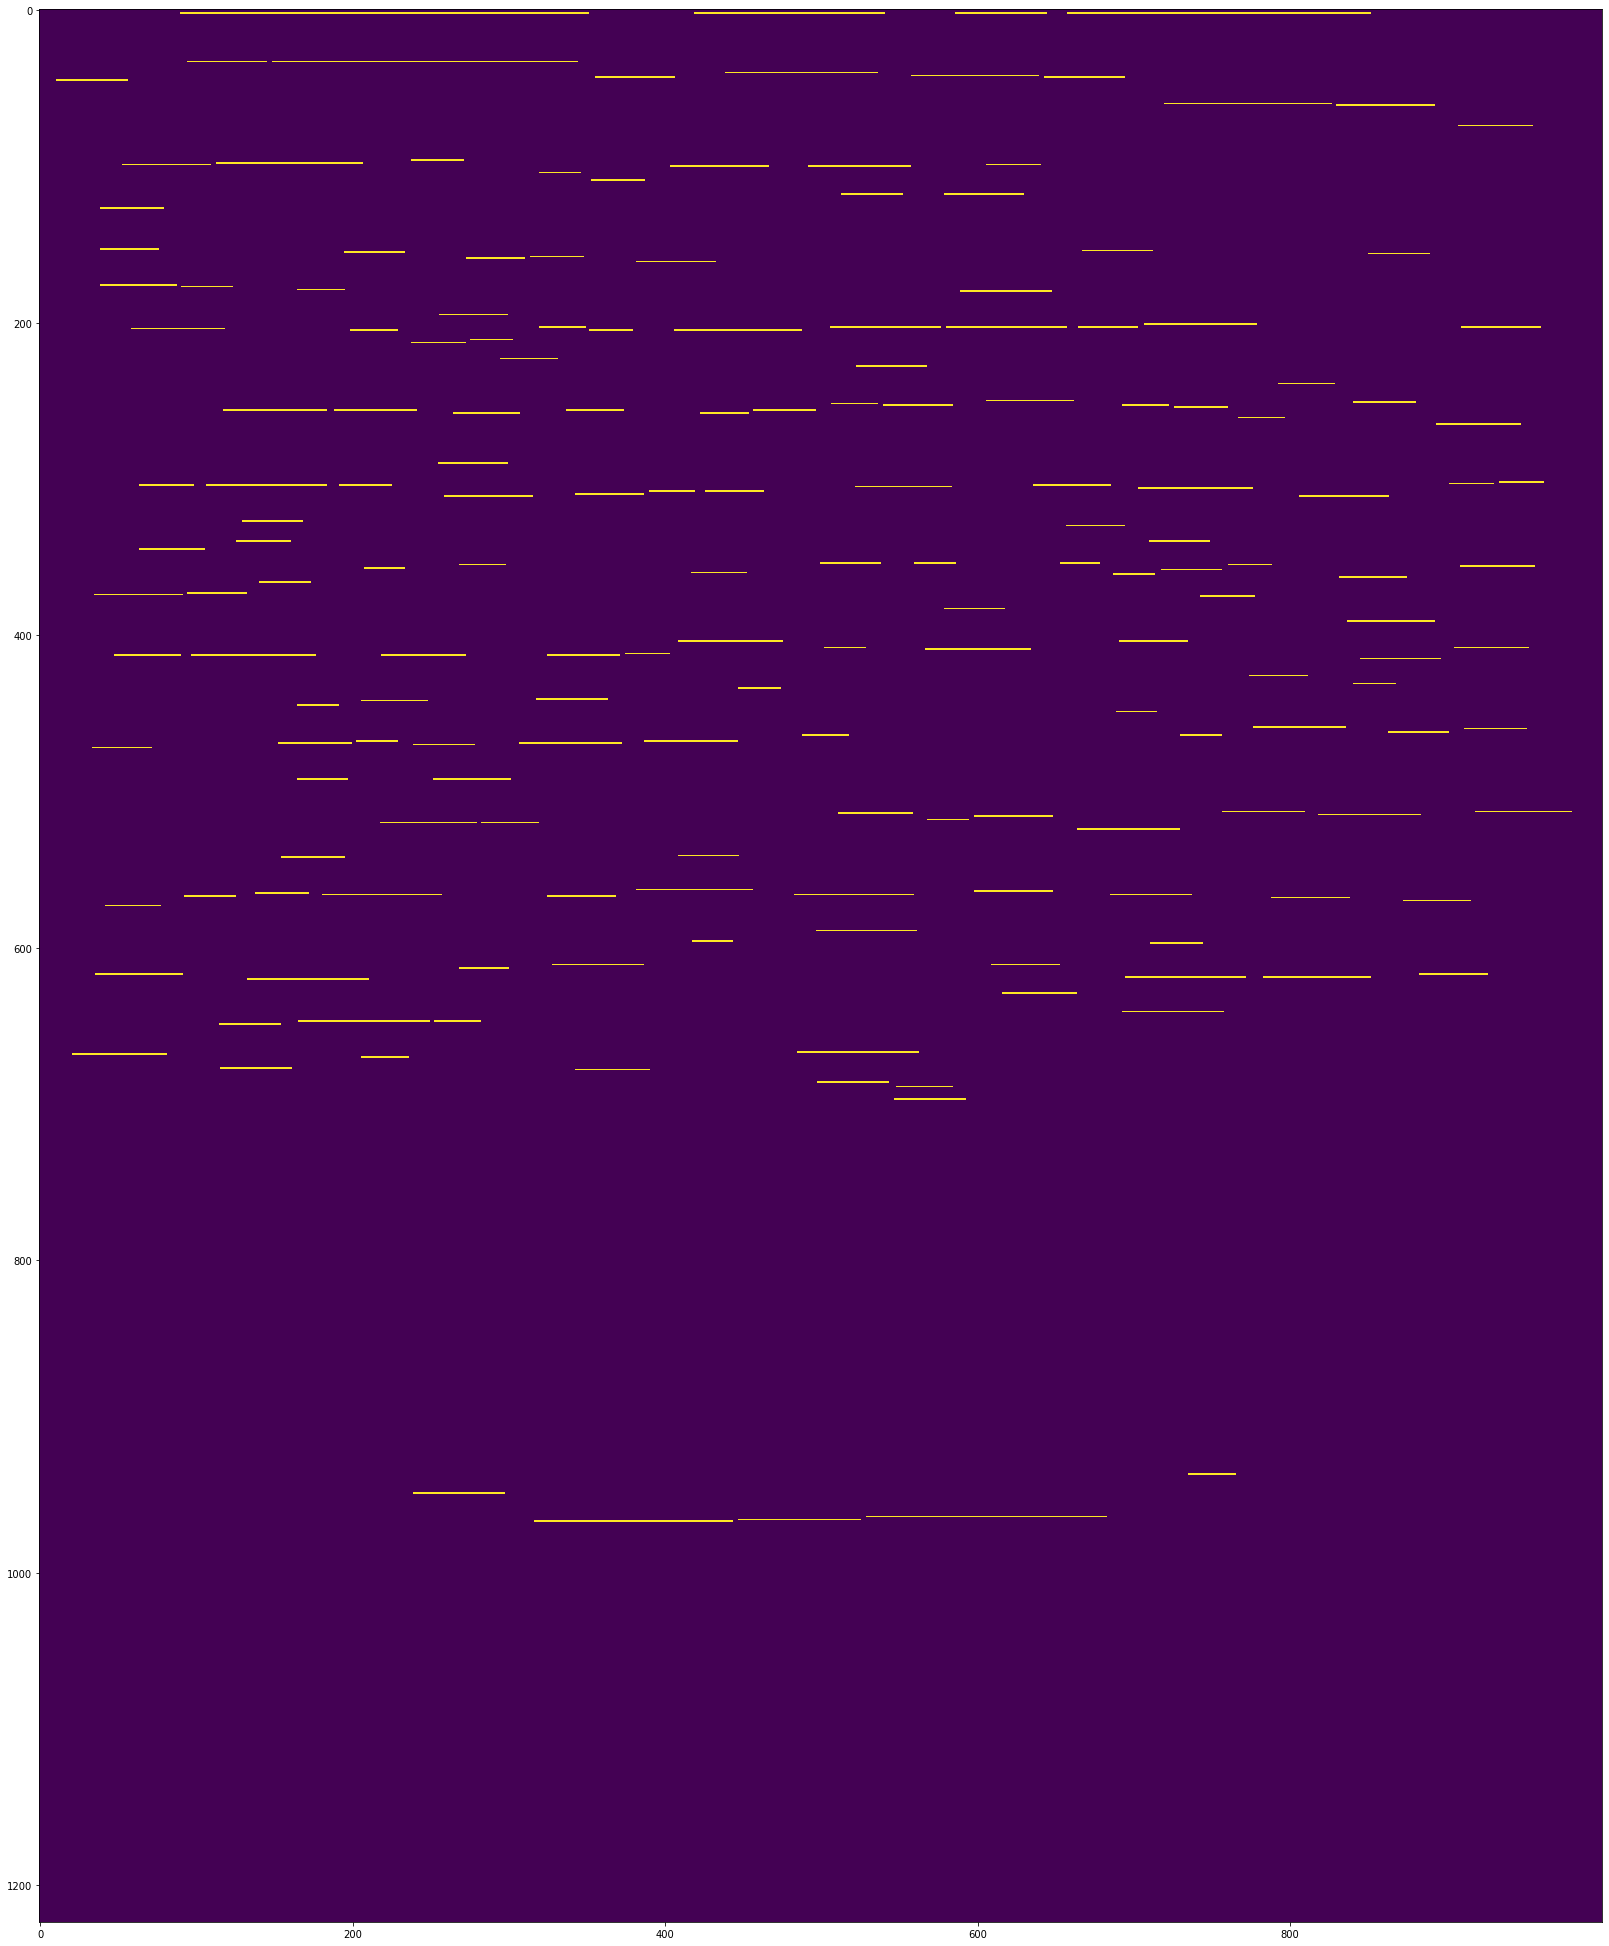

In [135]:
(h,w) = np.shape(image);
nimage = np.zeros((h,w), dtype=np.uint8);
for stat in nstats:
    cv.line(nimage, (int (stat[cv.CC_STAT_LEFT]), int (stat[cv.CC_STAT_TOP] + 1)), (stat[cv.CC_STAT_LEFT] + stat[cv.CC_STAT_WIDTH], int (stat[cv.CC_STAT_TOP] + 1)), 1, 1, cv.LINE_AA);
plt.imshow(nimage)
